In [1]:
from IPython.display import Image

In [2]:
# Figure 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

In [5]:
from __future__ import print_function
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C

%matplotlib inline

# Initialization

In [6]:
input_dim = 28 * 28 # 784
num_output_classes = 10

# Data reading

ใน tutorial นี้เราจะสร้างฟังก์ชั่น create_reader เพื่ออ่านเทรนดาต้าและเทสดาต้าโดยใช้ __[CTF deserializer.](https://cntk.ai/pythondocs/cntk.io.html?highlight=ctfdeserializer#cntk.io.CTFDeserializer)__ เลเบลเป็น 1-hot encoded ดูตัวอย่างจาก CNTK 103A tutorial 

In [18]:
# Read  a CTF formatted text using the CTF deserializer from file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    labelStream = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    
    deserailizer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels = labelStream, features = featureStream))
    
    return C.io.MinibatchSource(deserailizer, randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [19]:
# ensure we has data
data_found = False

for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"), os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")

print("Data directory is {0}".format(data_dir))

Data directory is data/MNIST


# Model Creation

In [20]:
input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

## Logistic Regression network setup

In [21]:
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform()):
        r = C.layers.Dense(num_output_classes, activation = None)(features)
        return r

In [22]:
z = create_model(input/255.0)

# Learning model parameters (Training)

In [23]:
loss = C.cross_entropy_with_softmax(z, label)

In [24]:
label_error = C.classification_error(z, label)

In [25]:
learning_rate = 0.2
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

In [26]:
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

## Run the trainer

In [27]:
# Initialize the parameters for the trainer
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [28]:
# Create the reader to training data set
reader_train = create_reader(train_file, True, input_dim, num_output_classes)

# Map the data streams to the input and labels.
input_map = {
    label  : reader_train.streams.labels,
    input  : reader_train.streams.features
} 

# Run the trainer on and perform model training
training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    
    # Read a mini batch from the training data file
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 2.4805, Error: 95.31%
Minibatch: 500, Loss: 0.2601, Error: 4.69%
Minibatch: 1000, Loss: 0.2617, Error: 3.12%
Minibatch: 1500, Loss: 0.4985, Error: 15.62%
Minibatch: 2000, Loss: 0.2414, Error: 7.81%
Minibatch: 2500, Loss: 0.1549, Error: 4.69%
Minibatch: 3000, Loss: 0.2792, Error: 7.81%
Minibatch: 3500, Loss: 0.2917, Error: 6.25%
Minibatch: 4000, Loss: 0.2821, Error: 4.69%
Minibatch: 4500, Loss: 0.2430, Error: 7.81%
Minibatch: 5000, Loss: 0.2301, Error: 6.25%
Minibatch: 5500, Loss: 0.1949, Error: 6.25%
Minibatch: 6000, Loss: 0.1626, Error: 3.12%
Minibatch: 6500, Loss: 0.2093, Error: 7.81%
Minibatch: 7000, Loss: 0.3136, Error: 9.38%
Minibatch: 7500, Loss: 0.2953, Error: 7.81%
Minibatch: 8000, Loss: 0.0868, Error: 0.00%
Minibatch: 8500, Loss: 0.1423, Error: 4.69%
Minibatch: 9000, Loss: 0.3341, Error: 9.38%


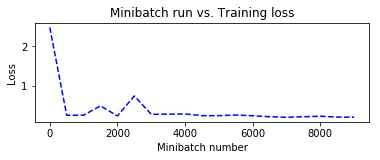

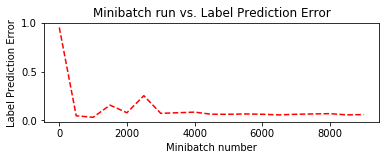

In [29]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

# Evaluation / Testing

In [43]:
# Read the training data
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

# Test data for trained model
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    
    # We are loading test data in batches specified by test_minibatch_size
    # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
    # with one pixel per dimension that we will encode / decode with the 
    # trained model.
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

# Average of evaluation errors of all test minibatches
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Average test error: 7.60%


In [44]:
out = C.softmax(z)

In [45]:
# Read the data for evaluation
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {input: reader_eval.streams.features} 

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].asarray()
img_data = data[input].asarray()
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [46]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [47]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [4, 5, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2, 2]
Predicted: [4, 6, 6, 7, 5, 8, 7, 4, 6, 1, 4, 0, 4, 9, 3, 7, 1, 2, 7, 5, 8, 6, 3, 2, 0]


Image Label:  4


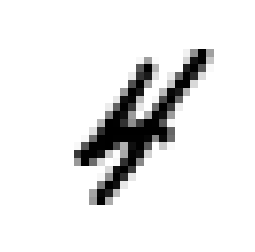

In [48]:
# Plot a random image
sample_number = 0
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

In [49]:
print(img_data[0])

[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.   14.  112. 

In [50]:
print(img_label[0])

[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
